In [4]:
! pip3 install patchify split-folders

In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify
import splitfolders
import random
from keras.utils import to_categorical


dtype: uint8, shape: (1800, 2880, 4), min: 0, max: 255


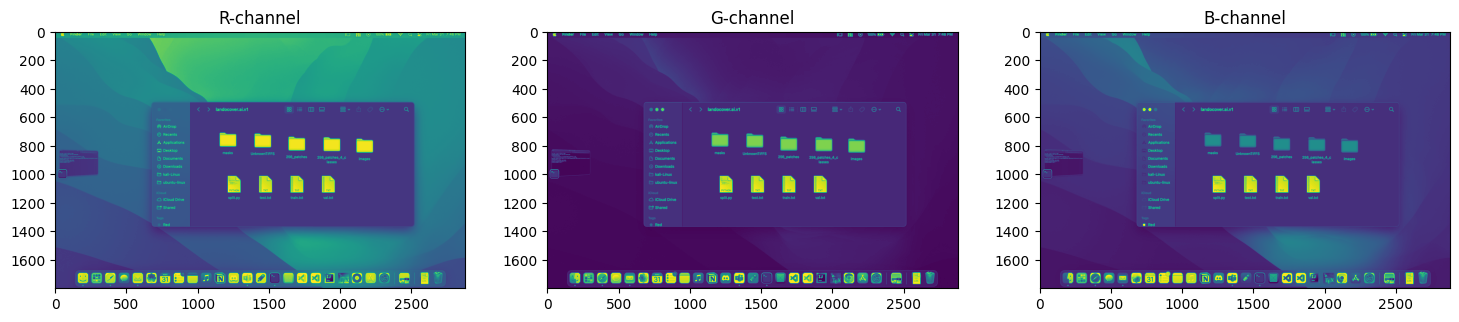

In [13]:

import cv2
import numpy as np
img = cv2.imread('1.png', cv2.IMREAD_UNCHANGED)
print(f'dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}')



plt.figure(figsize=(18,10))
plt.subplot(131)
plt.title("R-channel")
plt.imshow(img[:,:,0])
plt.subplot(132)

plt.title("G-channel")
plt.imshow(img[:,:,1])
plt.subplot(133)
plt.title("B-channel")
plt.imshow(img[:,:,2])
plt.show()

(4701, 4136)
[0 1 2 3 4] [12467974   352837  4757764  1491426   373335]


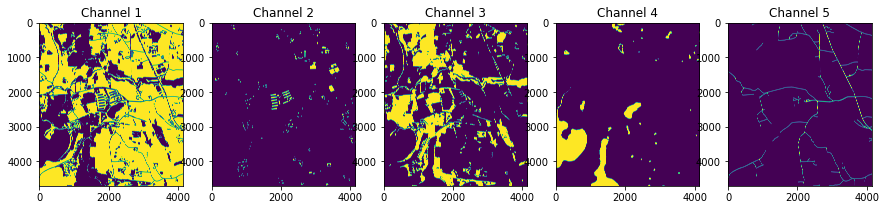

In [4]:
img=cv2.imread("../content/drive/MyDrive/fyp/landcover.ai.v1/masks/N-33-60-D-c-4-2.tif",0)
print(img.shape)
labels, count=np.unique(img, return_counts=True)
print(labels, count)
n_classes=len(labels)
# converting to categorical data
img=to_categorical(img, num_classes=n_classes)
plt.figure(figsize=(18,18))
for i in range(n_classes):
    plt.subplot(161+i)
    plt.title(f"Channel {i+1}")
    plt.imshow(img[:,:,i])
plt.show()

In [5]:
# accessing the count of the building class pixels
print(count[np.where(labels == 1)[0]])

[352837]


(4701, 4136)
[0 1] [19090499   352837]


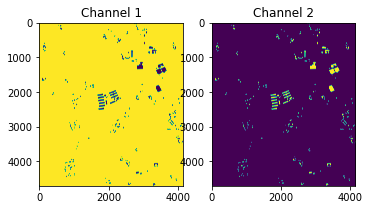

In [6]:
img=cv2.imread("../content/drive/MyDrive/fyp/landcover.ai.v1/masks/N-33-60-D-c-4-2.tif",0)
# only considereing buildings and converting rest all to unlabelled background
img[img > 1] = 0
print(img.shape)
labels, count=np.unique(img, return_counts=True)
print(labels, count)
n_classes=len(labels)
# converting to categorical data
img=to_categorical(img, num_classes=n_classes)
plt.figure(figsize=(18,18))
for i in range(n_classes):
    plt.subplot(161+i)
    plt.title(f"Channel {i+1}")
    plt.imshow(img[:,:,i])
plt.show()

In [7]:
root_dir = "../content/drive/MyDrive/fyp/landcover.ai.v1/"
patch_size = 256
img_dir = root_dir+"images/"
mask_dir = root_dir+"masks/"
# new_img_dir = root_dir+"256_patches/images/"
# new_mask_dir = root_dir+"256_patches/masks/"
new_img_dir = root_dir+"256_patches_4_classes/images/"
new_mask_dir = root_dir+"256_patches_4_classes/masks/"
try:
    os.makedirs(new_img_dir)
    os.makedirs(new_mask_dir)
except:
    print("Directory already available, so not created")
img_list = sorted(os.listdir(img_dir))
msk_list = sorted(os.listdir(mask_dir))

In [8]:
# the images and masks with decent amout of labels are seperated and used for training.
no_use_images=0
useful_images=0

# save the 256x256 with rules as mentioned above so that they can be used for data augumentation
# resizing will change the size of real image, so divide the image into patches of 256x256x3
for img in range(len(img_list)):
    img_name=img_list[img]
    mask_name=msk_list[img]
    print(f"Analysing {img_name} with {mask_name}")
    if img_name.endswith(".tif") and mask_name.endswith(".tif"):
        # at this point, image and mask variables contains a large sized images
        image=cv2.imread(img_dir+img_name,1)
        mask=cv2.imread(mask_dir+mask_name, 0)
        # here we crop the image so that size is near to the greatest multiple of 256
        size_x = (image.shape[1]//patch_size)*patch_size
        size_y = (image.shape[0]//patch_size)*patch_size
        # converting to pillow image
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        # cropping from top left corner
        image = image.crop((0, 0, size_x, size_y))
        mask = mask.crop((0, 0, size_x, size_y))
        image = np.array(image)
        mask = np.array(mask)
        # converting the large image into patches
        patches_image = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)
        
        # save the patches to local directory
        print(patches_image.shape, patches_mask.shape)
        for i in range(patches_image.shape[0]):
            for j in range(patches_image.shape[1]):
                patch_img = patches_image[i, j, :, :]
                patch_mask = patches_mask[i, j, :, :]
                # dropping the extra part created by patchify
                patch_img = patch_img[0]
                # seggregating useful and useless images
                val, counts=np.unique(patch_mask, return_counts=True)
                # 0th index store count of unlabelled pixels
                # if unlabelled pixels are atmost 95% of total pixels, then we have atleast 5% useful pixels.
                # and also atleast 5% of the mask pixels must be of building class.
                total_pixels=counts.sum()
                count_of_unlabelled_pixel_arr = counts[np.where(val == 0)[0]]
                count_of_building_pixel_arr = counts[np.where(val == 1)[0]]
                count_of_unlabelled_pixel = 0
                count_of_building_pixel = 0
                if(len(count_of_unlabelled_pixel_arr) != 0):
                    count_of_unlabelled_pixel=count_of_unlabelled_pixel_arr[0]
                if(len(count_of_building_pixel_arr) != 0):
                    count_of_building_pixel=count_of_building_pixel_arr[0]

                if(count_of_unlabelled_pixel/total_pixels < 0.95 and 
                    count_of_building_pixel/total_pixels > 0.05):
                    # only considereing buildings and converting rest all to unlabelled background
                    # patch_mask[patch_mask > 1] = 0
                    print(f"Patch {i}-{j} {patch_img.shape}, {patch_mask.shape} generated")
                    new_path_image = os.path.join(
                        new_img_dir, 
                        r"{}".format(img_name.split(".")[0]+'patch_'+str(i)+str(j)+'.tif'))
                    new_path_mask = os.path.join(
                        new_mask_dir, 
                        r"{}".format(mask_name.split(".")[0]+'patch_'+str(i)+str(j)+'.tif'))
                    cv2.imwrite(new_path_image, patch_img)
                    cv2.imwrite(new_path_mask, patch_mask)
                    useful_images+=1
                else:
                    no_use_images+=1

Analysing M-33-20-D-c-4-2.tif with M-33-20-D-c-4-2.tif
(37, 35, 1, 256, 256, 3) (37, 35, 256, 256)
Patch 4-33 (256, 256, 3), (256, 256) generated
Patch 5-28 (256, 256, 3), (256, 256) generated
Patch 5-29 (256, 256, 3), (256, 256) generated
Patch 5-32 (256, 256, 3), (256, 256) generated
Patch 6-29 (256, 256, 3), (256, 256) generated
Patch 23-3 (256, 256, 3), (256, 256) generated
Patch 35-24 (256, 256, 3), (256, 256) generated
Analysing M-33-20-D-d-3-3.tif with M-33-20-D-d-3-3.tif
(37, 35, 1, 256, 256, 3) (37, 35, 256, 256)
Patch 13-30 (256, 256, 3), (256, 256) generated
Patch 14-21 (256, 256, 3), (256, 256) generated
Patch 14-29 (256, 256, 3), (256, 256) generated
Patch 14-30 (256, 256, 3), (256, 256) generated
Patch 14-31 (256, 256, 3), (256, 256) generated
Patch 15-17 (256, 256, 3), (256, 256) generated
Patch 15-18 (256, 256, 3), (256, 256) generated
Patch 15-21 (256, 256, 3), (256, 256) generated
Patch 15-22 (256, 256, 3), (256, 256) generated
Patch 15-24 (256, 256, 3), (256, 256) ge

In [9]:
print("Useless images:",no_use_images)
print("Useful images: ", useful_images)
print("Total patches produced: ", no_use_images+useful_images)

Useless images: 41646
Useful images:  2476
Total patches produced:  44122


Inspect 1 patch image mask pair out of 2460
N-34-140-A-d-4-2patch_1916.tif N-34-140-A-d-4-2patch_1916.tif


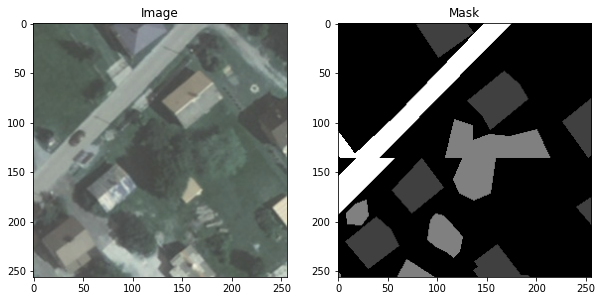

In [10]:
num_images = len(os.listdir(new_img_dir))
img_num = random.randint(0, num_images-1)
print(f'Inspect 1 patch image mask pair out of {num_images}')
new_img_list = sorted(os.listdir(new_img_dir))
new_mask_list = sorted(os.listdir(new_mask_dir))
print(new_img_list[img_num], new_img_list[img_num])
img_for_plot = cv2.imread(new_img_dir+new_img_list[img_num], 1)
mask_for_plot =cv2.imread(new_mask_dir+new_mask_list[img_num], 0)

plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [11]:
labels, count=np.unique(mask_for_plot, return_counts=True)
print(labels, count)

[0 1 2 4] [46104  8252  5787  5393]


In [12]:
# old_img_mask_dir = root_dir+"256_patches/"
# new_img_mask_dir = root_dir+"256_patches/flow_dir/"
old_img_mask_dir = root_dir+"256_patches_4_classes/"
new_img_mask_dir = root_dir+"256_patches_4_classes/flow_dir/"
splitfolders.ratio(old_img_mask_dir, output=new_img_mask_dir, seed=16, ratio=(0.80, 0.20))

Copying files: 4920 files [03:09, 26.00 files/s]


Inspect 1 patch image mask pair out of 1968
../content/drive/MyDrive/fyp/landcover.ai.v1/256_patches_4_classes/flow_dir/train/images/M-34-65-D-d-4-1patch_195.tif


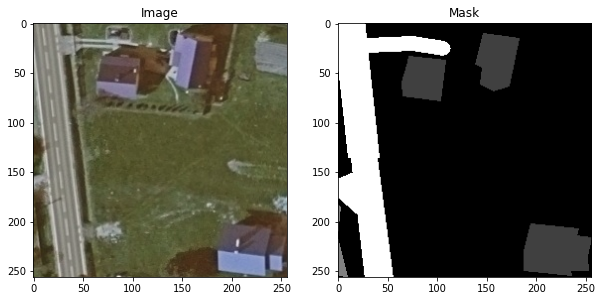

In [13]:
# checking
new_img_dir=new_img_mask_dir+"train/images/"
new_mask_dir=new_img_mask_dir+"train/masks/"
num_images = len(os.listdir(new_img_dir))
img_num = random.randint(0, num_images-1)
print(f'Inspect 1 patch image mask pair out of {num_images}')
new_img_list = sorted(os.listdir(new_img_dir))
new_mask_list = sorted(os.listdir(new_mask_dir))
print(new_img_dir+new_img_list[img_num])
img_for_plot = cv2.imread(new_img_dir+new_img_list[img_num], 1)
mask_for_plot = cv2.imread(new_mask_dir+new_mask_list[img_num], 0)

plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

Inspect 1 patch image mask pair out of 492
../content/drive/MyDrive/fyp/landcover.ai.v1/256_patches_4_classes/flow_dir/val/images/N-34-97-C-b-1-2patch_912.tif


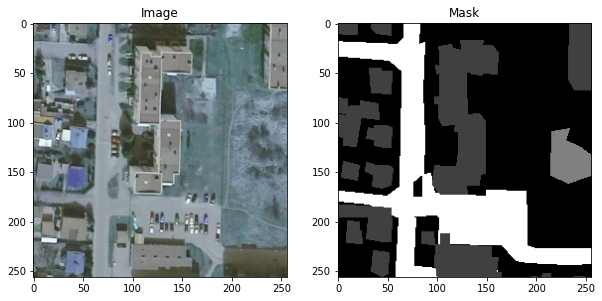

In [15]:
# checking
new_img_dir=new_img_mask_dir+"val/images/"
new_mask_dir=new_img_mask_dir+"val/masks/"
num_images = len(os.listdir(new_img_dir))
img_num = random.randint(0, num_images-1)
print(f'Inspect 1 patch image mask pair out of {num_images}')
new_img_list = sorted(os.listdir(new_img_dir))
new_mask_list = sorted(os.listdir(new_mask_dir))
print(new_img_dir+new_img_list[img_num])
img_for_plot = cv2.imread(new_img_dir+new_img_list[img_num], 1)
mask_for_plot = cv2.imread(new_mask_dir+new_mask_list[img_num], 0)

plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()